In [1]:
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(palette='magma')

In [2]:
ratings = pd.read_csv('../datasets/ml-latest/ratings.csv')

In [3]:
print(ratings.isnull().sum())

userId       2
movieId      0
rating       0
timestamp    0
dtype: int64


In [4]:
ratings = ratings.dropna().reset_index(drop=True)

In [5]:
ratings.shape

(699919, 4)

In [6]:
print(ratings.shape)
print(ratings['userId'].nunique())
print(ratings['movieId'].nunique())

(699919, 4)
7010
21752


In [7]:
ratings = ratings.drop(columns=['timestamp'])

#### Check best models on subset of data

In [8]:
select_movies = ratings.movieId.value_counts().head(1000).index.to_list()

In [9]:
ratings_sub = ratings.loc[ratings.movieId.isin(select_movies)]
ratings_sub.head()

,userId,movieId,rating
0,1.0,1,4.0
1,1.0,110,4.0
2,1.0,158,4.0
3,1.0,260,4.5
4,1.0,356,5.0


In [10]:
select_users = ratings_sub.userId.value_counts().head(1000).index.to_list()

In [11]:
ratings_sub = ratings_sub.loc[ratings_sub.userId.isin(select_users)]
del(ratings)
ratings_sub.shape

(241713, 3)

In [12]:
rm = ratings_sub.pivot(index='userId', columns='movieId', values='rating').fillna(0)
rm.head()

movieId,1,2,3,5,6,7,10,11,16,17,...,168252,171763,174055,176371,177765,187593,195159,202439,204698,207313
userId,,,,,,,,,,,,,,,,,,,,,
10.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14.0,2.5,2.5,0.0,0.0,0.0,0.0,4.5,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21.0,3.0,3.0,0.0,0.0,0.0,0.0,3.5,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.5,0.0,...,3.0,0.0,0.0,3.5,0.0,4.0,0.0,3.0,4.0,3.5
24.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,4.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [2]:
from surprise import SVD, Dataset, Reader, NMF
from cmfrec import CMF
from scipy.sparse import coo_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error as mse

In [14]:
ratings_sub = ratings_sub.reset_index(drop=True)

In [16]:
# split train and test set
test_set = ratings_sub.sample(int(0.2*637549))
train_set = ratings_sub[~ratings_sub.index.isin(test_set.index)]

In [17]:
def actual_vs_predicted_rating(actual_rating, predicted_rating, model):
    sns.histplot(actual_rating, kde=True, label='Actual Ratings')
    sns.histplot(predicted_rating, kde=True, color='orange', label='Predicted Ratings')
    
    # Add vertical lines for the mean of each distribution
    plt.axvline(np.mean(actual_rating), color='blue', label='Mean Actual Rating')
    plt.axvline(np.mean(predicted_rating), color='orange', linestyle='--', label='Mean Predicted Rating')
    
    # Add plot title and labels
    plt.title(f'Distribution of Actual vs. Predicted Ratings ({model})')
    plt.xlabel('Rating')
    plt.ylabel('Frequency')
    plt.legend()

### SVD and NMF model

In [18]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(train_set, reader)

Test set RMSE-----
RMSE for SVD: 0.7023064004291396
Test set RMSE-----
RMSE for NMF: 0.7931798950168849


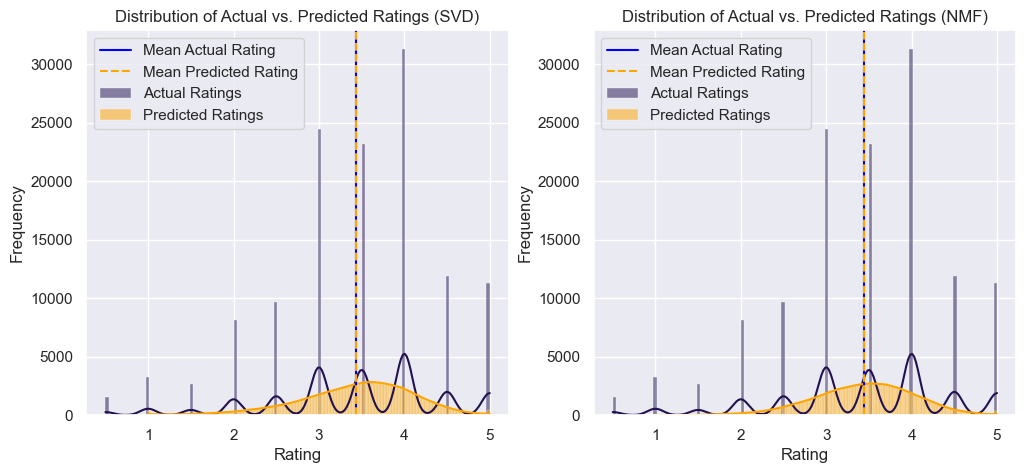

In [19]:
# initialize models
svd_model = SVD()
nmf_model = NMF()
names = ['SVD', 'NMF']
# build train data
trainset = data.build_full_trainset()
# fit all models on train dataset
plt.figure(figsize=(12, 5))
for i, model in enumerate([svd_model, nmf_model], start=1):
    # fit
    model.fit(trainset)
    # predict on seperate test set
    y_pred = [model.predict(i, j).est for i, j in zip(test_set.userId, test_set.movieId)]
    # calculate rmse
    rmse = mse(y_pred, test_set.rating.values)**0.5
    print("Test set RMSE-----")
    print(f"RMSE for {names[i-1]}: {rmse}")
    # plot actual vs predicted distribution
    plt.subplot(1, 2, i)
    actual_vs_predicted_rating(test_set.rating, y_pred, names[i-1])

plt.show()

### CMFREC model

In [15]:
from cmfrec import CMF

In [21]:
cmf_model = CMF(method='als')
train_set.columns = ['UserId', 'ItemId', 'Rating']  # Lib requires specific column names
cmf_model.fit(train_set)

Collective matrix factorization model
(explicit-feedback variant)


Test set RMSE-----
RMSE for CMF model: 0.7034965278713277


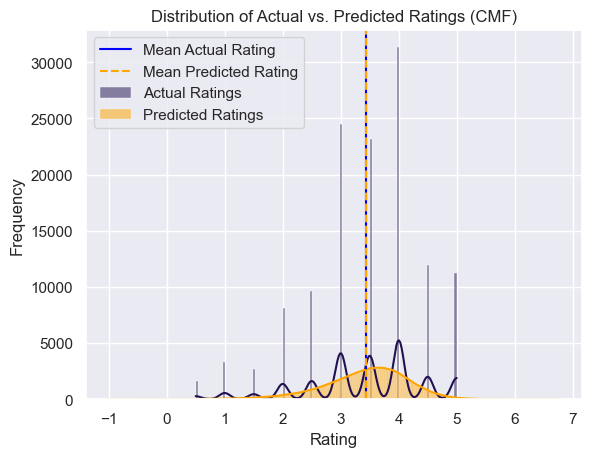

In [22]:
# plot distribution and rmse
# y_pred = [cmf_model.predict(i, j) for i, j in zip(test_set.userId, test_set.movieId)]
y_pred = cmf_model.predict(test_set.userId.values, test_set.movieId.values)
# calculate rmse
rmse = mse(y_pred, test_set.rating.values)**0.5
print("Test set RMSE-----")
print(f"RMSE for CMF model: {rmse}")
# plot actual vs predicted distribution
actual_vs_predicted_rating(test_set.rating, y_pred, 'CMF')
plt.show()

In [23]:
from itertools import product

In [23]:
params_dist = {
    'k': [5, 10, 25, 40, 60],
    'lambda_': [0.001, 0.01, 0.1, 1, 10]
}

best_param = None
best_score = float('inf')

param_names = list(params_dist.keys())
param_values = list(params_dist.values())

for combo in product(*param_values):
    # parameter combination
    params_to_test = dict(zip(param_names, combo))
    print('Current parameters:---', params_to_test)
    # init model
    cmf_model = CMF(**params_to_test)
    #fit model
    cmf_model.fit(train_set)
    # predict on test
    y_pred = cmf_model.predict(test_set.userId.values, test_set.movieId.values)
    # calculate rmse
    rmse = mse(y_pred, test_set.rating.values)**0.5
    print("Test set RMSE-----", rmse)
    # check if best score
    if rmse < best_score:
        best_score = rmse
        best_param = params_to_test

    del(cmf_model)

print("----------------"*10)
print(f"Best Score achieved: {best_score}")
print(f"Best hyperparameters: {best_param}")

Current parameters:--- {'k': 5, 'lambda_': 0.001}
Test set RMSE----- 0.7299006532303759
Current parameters:--- {'k': 5, 'lambda_': 0.01}
Test set RMSE----- 0.7308920725253766
Current parameters:--- {'k': 5, 'lambda_': 0.1}
Test set RMSE----- 0.723195637511326
Current parameters:--- {'k': 5, 'lambda_': 1}
Test set RMSE----- 0.723515854918987
Current parameters:--- {'k': 5, 'lambda_': 10}
Test set RMSE----- 0.7228591284014978
Current parameters:--- {'k': 10, 'lambda_': 0.001}
Test set RMSE----- 0.7131632849365248
Current parameters:--- {'k': 10, 'lambda_': 0.01}
Test set RMSE----- 0.7114919091977443
Current parameters:--- {'k': 10, 'lambda_': 0.1}
Test set RMSE----- 0.7101806450683927
Current parameters:--- {'k': 10, 'lambda_': 1}
Test set RMSE----- 0.7067620196650487
Current parameters:--- {'k': 10, 'lambda_': 10}
Test set RMSE----- 0.7039900864741823
Current parameters:--- {'k': 25, 'lambda_': 0.001}
Test set RMSE----- 0.72543539882881
Current parameters:--- {'k': 25, 'lambda_': 0.01}


In [ ]:
cmf_best = CMF(k=25, lambda_=10.0)

cmf_best.fit(train_set)

In [25]:
cmf_best.A_.shape, cmf_best.B_.shape

((1000, 25), (1000, 25))

In [28]:
train_set.UserId.value_counts()

UserId
76618     797
160061    785
25497     771
105053    763
94525     762
         ... 
146886    420
108537    419
172071    418
161740    416
130371    407
Name: count, Length: 1000, dtype: int64

In [26]:
top_10 = cmf_best.topN(130371, exclude=train_set[train_set['UserId'] == 130371]['ItemId'].values, output_score=True)
top_10

(array([1222,  858,  750, 1732,  903, 1203, 1208, 1228, 2288,  593],
       dtype=int64),
 array([4.7182574, 4.683993 , 4.6812415, 4.6533604, 4.637759 , 4.592905 ,
        4.5719404, 4.53652  , 4.5318804, 4.500791 ], dtype=float32))

In [44]:
from sklearn.metrics.pairwise import cosine_similarity

In [86]:
def user_user_sim(model, user_to_check=None):

    user_to_check = np.squeeze(np.where(model.user_mapping_ == user_to_check))
    user_to_check_vector = model.A_[user_to_check]
    sim_user_dict = {}
    
    for i, u_vec in enumerate(model.A_):
        
        u_id = model.user_mapping_[i]
        if u_id != user_to_check:
            sim_user_dict[u_id] = cosine_similarity(user_to_check_vector.reshape(1, -1), u_vec.reshape(1, -1))
    
    sim_user_dict = dict(sorted(sim_user_dict.items(), key=lambda x: x[1], reverse=True))
    
    return sim_user_dict


In [90]:
user_user_sim(cmf_best, 7570)

{7570: array([[1.0000001]], dtype=float32),
 18931: array([[0.6668072]], dtype=float32),
 149982: array([[0.640308]], dtype=float32),
 59590: array([[0.6255271]], dtype=float32),
 87597: array([[0.6176957]], dtype=float32),
 48068: array([[0.61069536]], dtype=float32),
 79098: array([[0.60761726]], dtype=float32),
 12556: array([[0.59167606]], dtype=float32),
 171993: array([[0.58612263]], dtype=float32),
 94925: array([[0.57923293]], dtype=float32),
 109270: array([[0.5748308]], dtype=float32),
 46265: array([[0.5705524]], dtype=float32),
 126901: array([[0.56683666]], dtype=float32),
 137218: array([[0.5655409]], dtype=float32),
 126310: array([[0.55648756]], dtype=float32),
 162288: array([[0.5533241]], dtype=float32),
 65491: array([[0.5503784]], dtype=float32),
 34269: array([[0.550114]], dtype=float32),
 169577: array([[0.5352959]], dtype=float32),
 151692: array([[0.53228503]], dtype=float32),
 158032: array([[0.5300388]], dtype=float32),
 105053: array([[0.5257159]], dtype=floa

In [87]:
cmf_best.user_mapping_

array([   198,    461,    487,    897,    974,   1677,   1917,   2172,
         2270,   2374,   2394,   2402,   2844,   3023,   3026,   3160,
         3469,   3517,   3589,   3663,   3951,   4092,   4127,   4182,
         4249,   4605,   4635,   4695,   4880,   4961,   5114,   5220,
         5235,   5283,   5427,   5889,   6116,   6386,   6494,   6735,
         6823,   6986,   7010,   7155,   7570,   8117,   8128,   8153,
         8227,   8240,   8774,   8978,   9246,   9288,   9401,   9448,
         9672,   9861,  10129,  10730,  10867,  11218,  11329,  11717,
        11811,  11933,  12155,  12556,  12634,  12725,  12734,  12901,
        13011,  13085,  13383,  13729,  13854,  13995,  14404,  14943,
        15069,  15496,  15529,  15651,  15774,  15957,  16325,  16552,
        16761,  17093,  17621,  17697,  17726,  18043,  18371,  18401,
        18510,  18589,  18688,  18931,  19358,  19433,  19718,  19965,
        19973,  20009,  20133,  20344,  20459,  20932,  21341,  21435,
      

In [115]:
# rm_svd = np.dot(svd_model.pu, svd_model.qi.T) + svd_model.default_prediction() + svd_model.bu + svd_model.bi
# print("RMSE:", mse(rm.values[rm > 0], rm_svd[rm > 0])**0.5)

In [2]:
ratings = pd.read_csv('../datasets/ml-latest/ratings.csv')
ratings = ratings.dropna().reset_index(drop=True)
ratings = ratings.drop(columns=['timestamp'])

In [3]:
ratings.columns = ['UserId', 'ItemId', 'Rating']
ratings.head()

,UserId,ItemId,Rating
0,1.0,1,4.0
1,1.0,110,4.0
2,1.0,158,4.0
3,1.0,260,4.5
4,1.0,356,5.0


In [4]:
ratings.dtypes

UserId    float64
ItemId      int64
Rating    float64
dtype: object

In [94]:
cmf_final = CMF(k=25, lambda_=10.0, n_jobs=-1)

cmf_final.fit(ratings)

Collective matrix factorization model
(explicit-feedback variant)


In [95]:
cmf_final.topN(452, exclude=ratings[ratings['UserId'] == 452]['ItemId'].values)

array([  3101,   1183,    509,    144,     36,   2336,   4306, 127098,
          265,   2908], dtype=int64)

In [3]:
import pickle
import os

In [102]:
# save model
output_dir = "../models/cmfrec_model/"
os.makedirs(output_dir, exist_ok=True)

with open("../models/cmfrec_model/cmf_full.pkl", 'wb') as file:
    pickle.dump(cmf_final, file)

In [4]:
with open("../models/cmfrec_model/cmf_full.pkl", 'rb') as file:
    cmf_full = pickle.load(file)

In [9]:
cmf_full.topN(500, 10, exclude=ratings[ratings['UserId'] == 100]['ItemId'].values, output_score=True)

(array([ 92259,    318,    527,   2324,     50,   2571, 171011,   2959,
          7153, 170705], dtype=int64),
 array([5.1301184, 5.089105 , 4.9636917, 4.931216 , 4.909693 , 4.8359876,
        4.8311114, 4.8307705, 4.8251886, 4.813703 ], dtype=float32))

In [24]:
np.where(cmf_full.user_mapping_ == 500)[0][0]

499

#### Things to note:
- *cmf A_ and B_ matrix can be converted to scipy coo matrix for better handling.*
- *user and item indices in the sparse matrix corresponds to user and item mapping of the model.*
  - *Example - for a user-movie matrix (u x m), a row index can be correlated to the user_mapping array of the model to find out the original user ID.*

In [13]:
from sklearn.neighbors import NearestNeighbors

In [22]:
n_neighbors = 20
metric = 'cosine'
algorithm = 'brute'

nn_user = NearestNeighbors(n_neighbors=n_neighbors, metric=metric, algorithm=algorithm)
nn_movie = NearestNeighbors(n_neighbors=n_neighbors, metric=metric, algorithm=algorithm)

nn_user.fit(cmf_full.A_)
nn_movie.fit(cmf_full.B_)

NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=20)

In [25]:
nn_user.kneighbors(cmf_full.A_[4584].reshape(1, -1))

(array([[0.        , 0.2021482 , 0.26811266, 0.27708375, 0.28836048,
         0.2884621 , 0.30174148, 0.3074383 , 0.31079096, 0.3129415 ,
         0.3143708 , 0.3211689 , 0.32510054, 0.3284018 , 0.33325082,
         0.33452088, 0.3347674 , 0.33510882, 0.3415082 , 0.34182525]],
       dtype=float32),
 array([[  4584, 114840,  77751,  82050, 155780, 103904, 111605, 158744,
          14333, 127228,  58340, 168781,  69268,   7991,   5852, 115628,
         110212,  15414, 154093, 103760]], dtype=int64))

In [29]:
with open("../models/cmfrec_model/cmf_user_kneighbors.pkl", 'wb') as f:
    pickle.dump(nn_user, f)
with open("../models/cmfrec_model/cmf_item_kneighbors.pkl", 'wb') as f:
    pickle.dump(nn_movie, f)

In [34]:
dist, idx = nn_user.kneighbors(cmf_full.A_[54].reshape(1, -1))
dist.shape, idx.shape

((1, 20), (1, 20))

In [28]:
from scipy.sparse import coo_matrix

In [25]:
user_idx = {id_: idx for idx, id_ in enumerate(ratings['userId'].unique())}
movie_idx = {id_: idx for idx, id_ in enumerate(ratings['movieId'].unique())}

ratings['user_idx'] = ratings['userId'].map(user_idx)
ratings['movie_idx'] = ratings['movieId'].map(movie_idx)

user_movie_mat = coo_matrix(
    (ratings['rating'], (ratings['user_idx'], ratings['movie_idx'])),
    shape=(len(user_idx), len(movie_idx))
)

In [29]:
user_movie_mat = user_movie_mat.tocsr()

In [35]:
del(ratings)